# Pneumonia Classification in Chest X-rays using CNN

This notebook presents the development of a Convolutional Neural Network (CNN) designed to detect pneumonia from **chest X-ray images**.

### 1. Environment Setup and Imports

In this section, the necessary libraries for tensor processing (PyTorch), visualization (Matplotlib), and evaluation metrics were loaded.


In [8]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import sys 

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

### 2. Data Loading and Preprocessing

The system paths were configured to access local modules and the dataloaders were initialized. An image size of 228x228 was selected to balance detail and computational cost.


In [9]:
# Go up one level to reach the project root and enter 'src'
sys.path.append(os.path.abspath(os.path.join('..')))

# Import custom dataloaders
from src.data.dataloaders import get_loaders

# Execute the function to get data loaders
# batch_size=32 is a stable standard for training
train_loader, test_loader = get_loaders(batch_size=32, img_size=228)

print(f"train_loader variable defined: {train_loader is not None}")

train_loader variable defined: True


### 3. Model Architecture (PneumoniaCNN)

A custom architecture with 3 convolutional blocks was designed. Each block extracted features ranging from low-level edges to high-level lung opacity patterns.


In [10]:
class PneumoniaCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(PneumoniaCNN, self).__init__()
        
        # BLOCK 1: Initial feature extraction
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # BLOCK 2: Depth increase
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # BLOCK 3: Complex features extraction
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            # Output size: 28x28x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.flatten = nn.Flatten()
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5), # Regularization was added to prevent overfitting
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

# The model was instantiated and dimensions were verified
model = PneumoniaCNN(num_classes=2)
print("Model structure was successfully verified.")

Model structure was successfully verified.


### 4. Training Configuration

The hardware was selected. Since an Apple M1 chip was used, the Metal Performance Shaders (MPS) backend was prioritized to leverage the integrated GPU, falling back to CPU only if necessary.


In [11]:
# Hardware selection (Optimized for Apple M1/M2/M3)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Training on: Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Training on: NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Training on: CPU")

model = model.to(device)

# CrossEntropyLoss was chosen for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer was initialized with a learning rate of 1e-4
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# A scheduler was implemented to reduce LR on plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

Training on: Apple Silicon GPU (MPS)


### 5. Training Loop Definition

A function was created to manage the training process, error calculation, and weight optimization.


In [12]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

    best_loss = float("inf")
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct_test / total_test

        # Save the best model based on test loss
        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved")
        
        # Metrics were stored in history
        history['train_loss'].append(epoch_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(epoch_acc)
        history['test_acc'].append(test_acc)
        
        print(f"Epoch [{epoch+1}/{epochs}] - "
      f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% - "
      f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

        
    return history

### 6. Visualization of Results

A plotting function was defined to evaluate the model's convergence.


In [13]:
def plot_results(history):
    plt.figure(figsize=(14, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['test_loss'], label='Test')
    plt.title('Loss History')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['test_acc'], label='Test')
    plt.title('Accuracy History')
    plt.legend()
    
    plt.show()

### 7. Experiment Execution

The training process was executed for 10 epochs and the results were visualized.


Best model saved
Epoch [1/10] - Train Loss: 0.2571, Train Acc: 89.11% - Test Loss: 0.5465, Test Acc: 80.77%
Epoch [2/10] - Train Loss: 0.1268, Train Acc: 95.53% - Test Loss: 1.0271, Test Acc: 70.35%
Epoch [3/10] - Train Loss: 0.1107, Train Acc: 95.51% - Test Loss: 0.6058, Test Acc: 80.45%
Epoch [4/10] - Train Loss: 0.1006, Train Acc: 96.30% - Test Loss: 1.1542, Test Acc: 72.12%
Epoch [5/10] - Train Loss: 0.0859, Train Acc: 96.74% - Test Loss: 0.8565, Test Acc: 79.81%
Epoch [6/10] - Train Loss: 0.0807, Train Acc: 96.74% - Test Loss: 0.9874, Test Acc: 77.56%
Epoch [7/10] - Train Loss: 0.0765, Train Acc: 97.01% - Test Loss: 1.2493, Test Acc: 74.36%
Epoch [8/10] - Train Loss: 0.0657, Train Acc: 97.68% - Test Loss: 0.9195, Test Acc: 80.61%
Epoch [9/10] - Train Loss: 0.0638, Train Acc: 97.45% - Test Loss: 1.3093, Test Acc: 76.60%
Epoch [10/10] - Train Loss: 0.0599, Train Acc: 97.72% - Test Loss: 1.3049, Test Acc: 75.32%


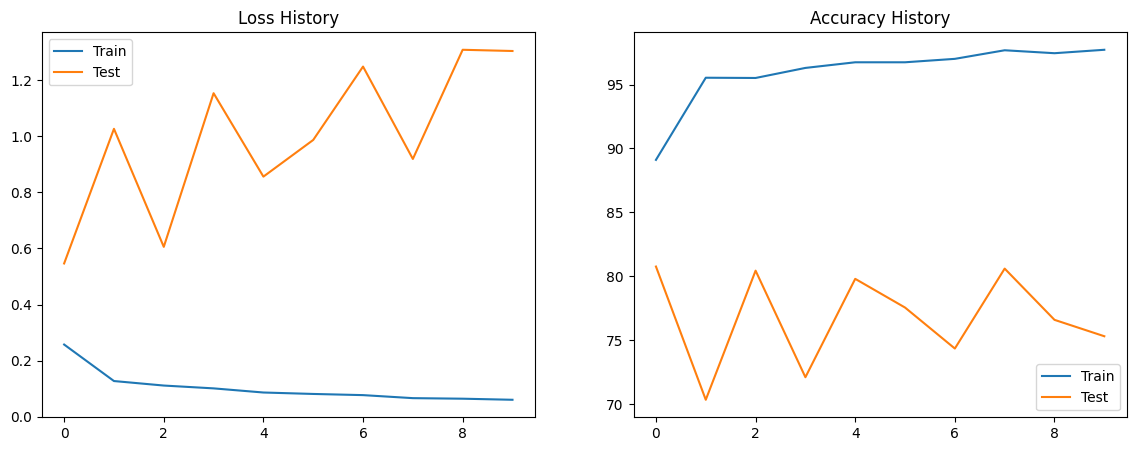

In [14]:
# Define number of epochs
NUM_EPOCHS = 10 

# Train the model
history = train_model(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    epochs=NUM_EPOCHS
)

# Plot the training results
plot_results(history)
